Math 5750/6880: Mathematics of Data Science \
Project 2

# 1. Clustering Gaussian Blobs using $k$-means

In [4]:
import numpy as np
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler

# Generate 5 Gaussian blobs in 10 dimensions
X, y_true = make_blobs(
    n_samples=1000,
    centers=5,
    n_features=10,
    cluster_std=1.5,
    random_state=1)        # reproducibility
X = StandardScaler().fit_transform(X)

print(type(X),X.shape)
print(type(y_true),y_true.shape)

<class 'numpy.ndarray'> (1000, 10)
<class 'numpy.ndarray'> (1000,)


In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix
from scipy.stats import mode

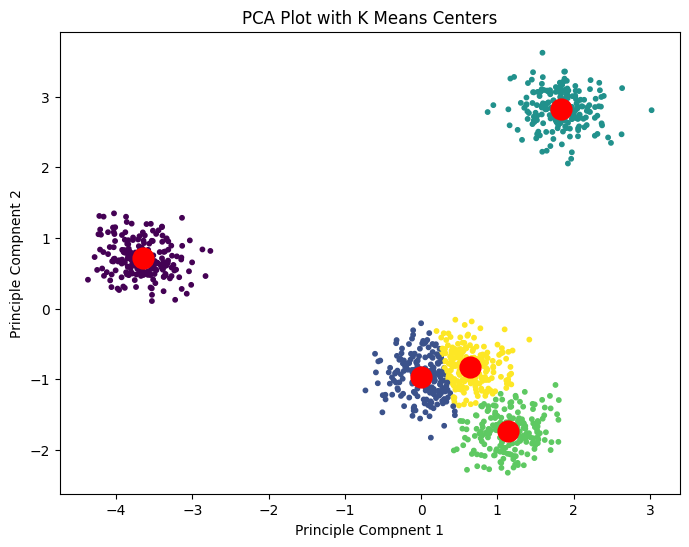

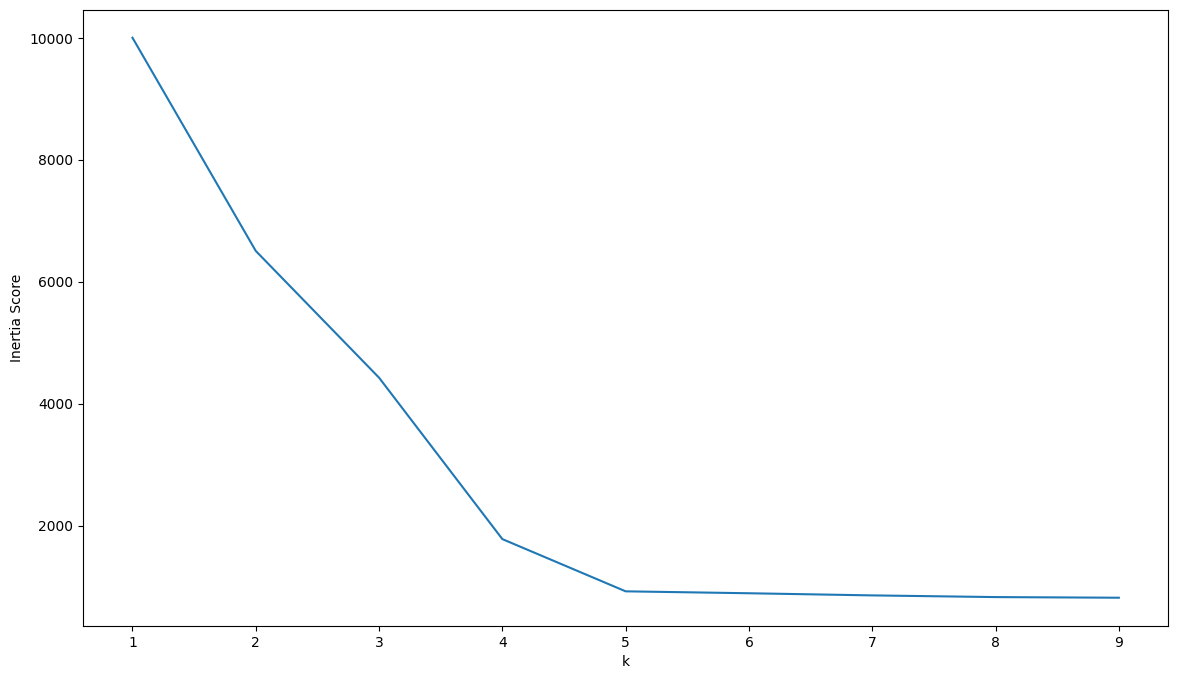

   k       inertia
0  1  10000.000000
1  2   6504.839876
2  3   4426.496681
3  4   1780.417264
4  5    924.315996
5  6    892.781349
6  7    857.670068
7  8    830.013603
8  9    819.534079


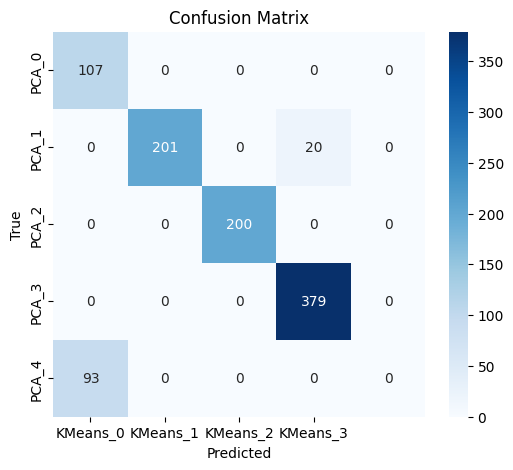

In [15]:
#PCA Clustering
X_PCA = PCA(n_components=2).fit_transform(X)

#kMean Model
kmeans_model = KMeans(init='k-means++', n_clusters=5, n_init=10, random_state=42)
kmeans_model.fit(X_PCA)

#Lables and Centers
labels = kmeans_model.labels_
centers = kmeans_model.cluster_centers_

#Plot PCA points colored by cluster
plt.figure(figsize=(8,6))
plt.scatter(X_PCA[:, 0], X_PCA[:, 1], c=labels, cmap='viridis', s=10)
plt.scatter(centers[:, 0], centers[:, 1], marker='o', s=169, linewidths=3, color='red', zorder=10)
plt.title("PCA Plot with K Means Centers")
plt.xlabel("Principle Compnent 1")
plt.ylabel("Principle Compnent 2")
plt.show()

#Elbow Analysis
ks = range(1,10)
scores = []

for k in ks:
    model = KMeans(n_clusters=k)
    y_pred = model.fit_predict(X)
    scores.append(-model.score(X))

#Plot Elbow Curve
fig = plt.figure(figsize=(14, 8))
plt.plot(ks, scores)
plt.ylabel('Inertia Score')
plt.xlabel('k')
plt.show()

results = pd.DataFrame({"k": ks, "inertia": scores})
print(results)

#Confusion Matrix
pca_kmeans = KMeans(n_clusters=5, random_state=42)
y_true = pca_kmeans.fit_predict(X_PCA)
y_pred = kmeans_model.labels_

#Match Predictions and PCA Clusters
mapped_labels = np.zeros_like(y_pred)
for cluster in np.unique(y_pred):
    mask = (y_pred == cluster)
    mapped_labels[mask] = mode(y_true[mask], keepdims=True)[0]

cm = confusion_matrix(y_true, mapped_labels)

#Confusion Matrix Heatmap
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=[f"KMeans_{i}" for i in np.unique(mapped_labels)],
            yticklabels=[f"PCA_{i}" for i in np.unique(y_true)])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# 2. Clustering Fashion-MNIST using $k$-means

In [4]:
import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import StandardScaler

# Load Fashion-MNIST from OpenML
# Classes (0-9): T-shirt/top, Trouser, Pullover, Dress, Coat, Sandal, Shirt, Sneaker, Bag, Ankle boot
X, y = fetch_openml("Fashion-MNIST", version=1, as_frame=False, parser="auto", return_X_y=True)
y = y.astype(int)

print(type(X),X.shape)
print(type(y),y.shape)

<class 'numpy.ndarray'> (70000, 784)
<class 'numpy.ndarray'> (70000,)


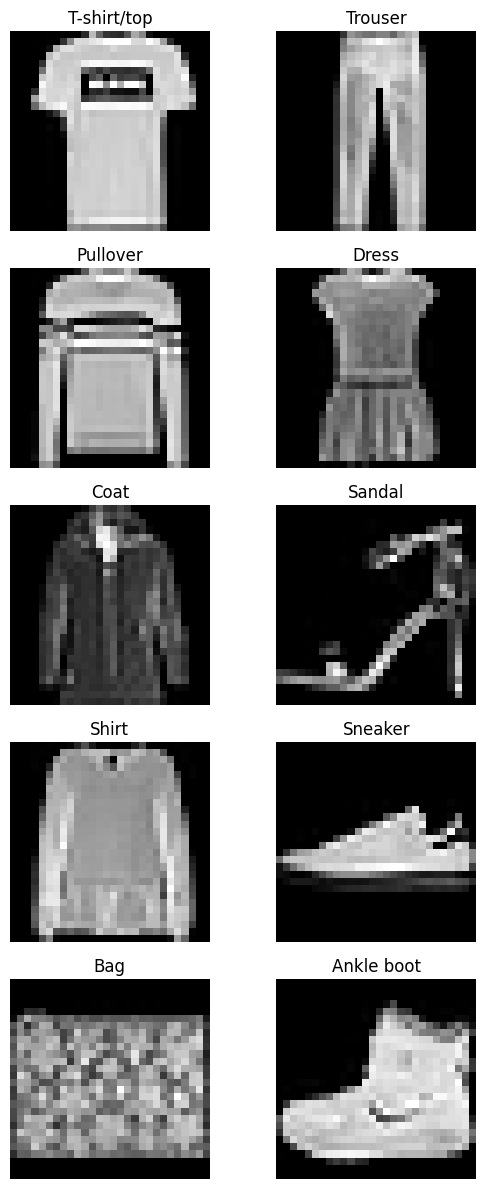

KMeans(n_clusters=10, n_init=10)

In [9]:
#Viszuliaing Dataset
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]
fig, axes = plt.subplots(5, 2, figsize=(6, 12))
axes = axes.ravel()

for i in range(10):
    idx = np.where(y == i)[0][0]
    img = X[idx].reshape(28, 28)
    axes[i].imshow(img, cmap="gray")
    axes[i].set_title(class_names[i])
    axes[i].axis("off")
plt.tight_layout()
plt.show()

#K-Means
kmeans_model = KMeans(n_clusters=10, n_init=10)
kmeans_model.fit(X)

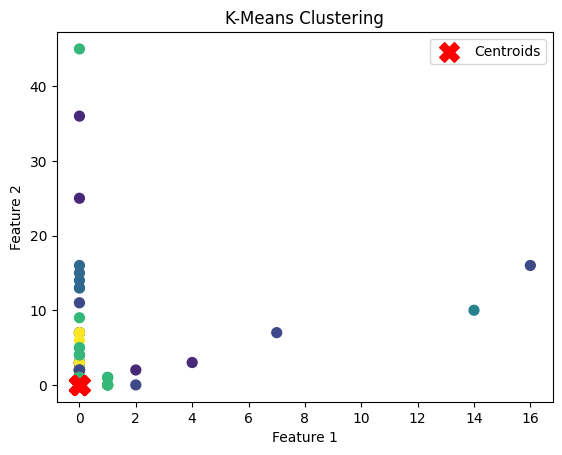

In [15]:
labels = kmeans_model.labels_
cluster_centers = kmeans_model.cluster_centers_
plt.scatter(X[:, 0], X[:, 1], c=labels, s=50, cmap='viridis')
plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], s=200, marker='X', c='red', label='Centroids')
plt.title('K-Means Clustering')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.show()

# 3. Dimensionality reduction for Fashion-MNIST

In [ ]:
# your code here

# 4. Clustering Fashion-MNIST using spectral clustering

In [ ]:
# your code here